In [1]:
import numpy as np
import math
import csv 
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import seaborn as sns
import os
import imageio
import colorcet as cc
import cartopy.crs as ccrs
import stripy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,6)},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")

/Users/cygnari/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2) + np.power(z, 2))
    colat = np.arctan2(np.sqrt(np.power(x, 2) + np.power(y, 2)), z)
    lon = np.arctan2(y, x)
    return r, colat, lon

In [3]:
def latlon(x, y, z): # returns latitude and longitude in degrees 
    r, colat, lon = cart2sph(x, y, z)
    return lon, colat

In [4]:
point_count = 2562

In [136]:
data = np.zeros((101, point_count, 7)) # x y z vorticity lon lat, passive tracer

In [137]:
with open('direct_output.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    for row in reader:
        t = i // point_count
        point = i % point_count
        data[t, point, 0:4] = row
#         lon, lat = latlon(*row[0:3])
        lon, lat = latlon(*row[0:3])
        data[t, point, 4:6] = lon, lat
        if (t == 0):
            data[t, point, 6] = lat - math.pi / 2
        else:
            data[t, point, 6] = data[t-1, point, 6]
        i += 1
        if i >= 101 * point_count:
            break
#         print(row)
#     for i in range(2):
#         print(reader.next())
#         spamwriter.writerow([points[i][0], points[i][1], points[i][2], values[i]])

In [138]:
data[3,0,:]

array([ 0.        ,  0.        ,  1.        ,  0.897617  ,  0.        ,
        0.        , -1.57079633])

In [139]:
filenames = []
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)

resX = 360
resY = 180

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)

for t in range(101):
    spherical_triangulation = stripy.sTriangulation(lons=data[t,:,4], lats=math.pi/2 - data[t,:,5])
    interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=data[t,:,3])
    grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)
    fig = plt.figure()
    ax1  = plt.subplot(projection=ccrs.Mollweide())
    ax1.coastlines()
    ax1.set_global()
    img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-10.2, vmax=10.2)
    cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Tracer Concentration')
    plt.figtext(0.15, 0.17, f'Time {t * 0.01}')
    plt.title('Time Evolution of Vorticity by the Barotropic Vorticity Equations with Remeshing')
    filename = f'./{t}time.png'
    plt.savefig(filename)
    filenames.append(filename)
    fig.clear()
    plt.clf()
    plt.close(fig)

with imageio.get_writer(f'./BVE_vor_{point_count}_remesh.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            writer.append_data(image)
            writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_59429/2140770328.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [130]:
spherical_triangulation = stripy.sTriangulation(lons=data[1,:,4], lats=math.pi/2 - data[1,:,5])

In [131]:
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)

In [132]:
interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=3, zdata=data[1,:,3])

In [133]:
resX = 360
resY = 180

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)

In [134]:
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

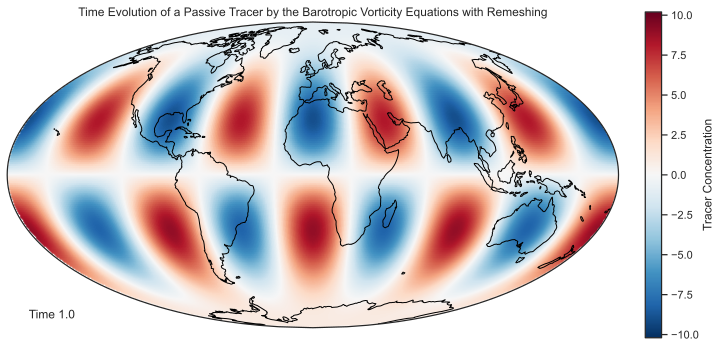

In [135]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Mollweide())
ax1.coastlines()
ax1.set_global()
img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-10.2, vmax=10.2)
cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Tracer Concentration')
plt.title('Time Evolution of a Passive Tracer by the Barotropic Vorticity Equations with Remeshing')
plt.figtext(0.15, 0.17, f'Time {1.00}')
# plt.show()
plt.savefig('bve_2562_vor_t1_remesh.png')

In [120]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Mollweide())
ax1.coastlines()
ax1.set_global()
# img = ax1.imshow(spherical_triangulation, extent=np.degrees(extent_globe))
ax1.scatter(np.degrees(spherical_triangulation.lons), np.degrees(spherical_triangulation.lats), transform=ccrs.PlateCarree())
plt.show()

In [ ]:
np.rad2deg(spherical_triangulation.lons)

In [39]:
data[:,:,3].min()

-10.1684